#### Imports and Read Data

In [426]:
import datetime
from itertools import chain, combinations
from time import perf_counter
from itertools import zip_longest

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pyarrow as pa
import numpy as np
from utils import load_saved_data, get_connection, get_data
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, MSTL
#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace, ERM, Normality
from hierarchicalforecast.utils import aggregate

In [427]:
# df = load_saved_data()
# conn = get_connection()
# df = get_data(conn, 2018, 2018, 2_000_000, 0)
df = pd.read_feather('../data/2018.feather')

In [428]:
display(df.isnull().sum()/2e6 * 100)


created_date                       0.00000
closed_date                        1.70500
agency                             0.00000
complaint_type                     0.00000
status                             0.00000
resolution_action_updated_date     0.80440
borough                            0.04135
descriptor                         0.82090
resolution_description             7.17155
incident_zip                       4.29605
city                               4.26965
latitude                           7.28845
longitude                          7.28845
due_date                          54.34260
bbl                               21.94385
dtype: float64

#### Drop, Fill, and Explore

In [429]:

current_date = pd.Timestamp.now().normalize()
# remove impossible records
# (close in future)
df = df.drop(df[df['closed_date']>current_date].index)
# (close before created)
df = df.loc[(df['closed_date']>df['created_date'])|(df['closed_date'].isnull())]
# Fill borough missing with unspecified
df['borough'].fillna('Unspecified', inplace=True)

In [430]:
df.dtypes.value_counts()

string                    9
timestamp[ns][pyarrow]    4
double[pyarrow]           2
Name: count, dtype: int64

In [431]:
df.dtypes

created_date                      timestamp[ns][pyarrow]
closed_date                       timestamp[ns][pyarrow]
agency                                   string[pyarrow]
complaint_type                           string[pyarrow]
status                                   string[pyarrow]
resolution_action_updated_date    timestamp[ns][pyarrow]
borough                                  string[pyarrow]
descriptor                               string[pyarrow]
resolution_description                   string[pyarrow]
incident_zip                             string[pyarrow]
city                                     string[pyarrow]
latitude                                 double[pyarrow]
longitude                                double[pyarrow]
due_date                          timestamp[ns][pyarrow]
bbl                                      string[pyarrow]
dtype: object

In [432]:
display(df.describe())
display(df.describe(include='string'))


,created_date,closed_date,resolution_action_updated_date,latitude,longitude,due_date
count,1920469,1886369,1904387,1.791866e+06,1.791866e+06,906126
mean,2018-08-22 15:50:14.612456192,2018-09-10 21:26:38.803641856,2018-09-10 13:46:45.311385856,4.072612e+01,-7.392455e+01,2018-09-02 04:23:45.924006400
min,2018-04-13 18:06:41,2018-04-13 18:17:17,2018-04-04 15:13:30,4.049895e+01,-7.425473e+01,2018-04-13 19:07:03
25%,2018-06-19 03:42:04,2018-06-26 15:58:58,2018-06-27 01:38:27.500000,4.066442e+01,-7.397026e+01,2018-06-24 01:31:52.500000
50%,2018-08-23 00:16:46,2018-09-04 02:29:39,2018-09-04 12:51:00,4.071711e+01,-7.392746e+01,2018-08-27 07:44:21
75%,2018-10-25 10:26:47,2018-11-07 14:14:43,2018-11-08 00:00:00,4.079731e+01,-7.387598e+01,2018-10-30 09:03:16
max,2018-12-31 23:59:56,2024-02-12 11:40:56,2024-02-12 11:40:59,4.091294e+01,-7.370038e+01,2022-07-21 02:22:26
std,NaN,NaN,NaN,8.578650e-02,8.412697e-02,NaN


,agency,complaint_type,status,borough,descriptor,resolution_description,incident_zip,city,bbl
count,1920469,1920469,1920469,1920469,1904062,1778378,1850201,1850720,1530910
unique,29,247,9,6,1164,804,588,414,359482
top,NYPD,Noise - Residential,Closed,BROOKLYN,Loud Music/Party,The Police Department responded to the complai...,11226,BROOKLYN,4015110001
freq,576240,161779,1885045,611047,185466,208709,31357,598913,1561


In [433]:
df[(df['borough']=='Unspecified')]['created_date'].count()#/2e6

27826

In [434]:
df['closed_date'].isnull().sum()

34100

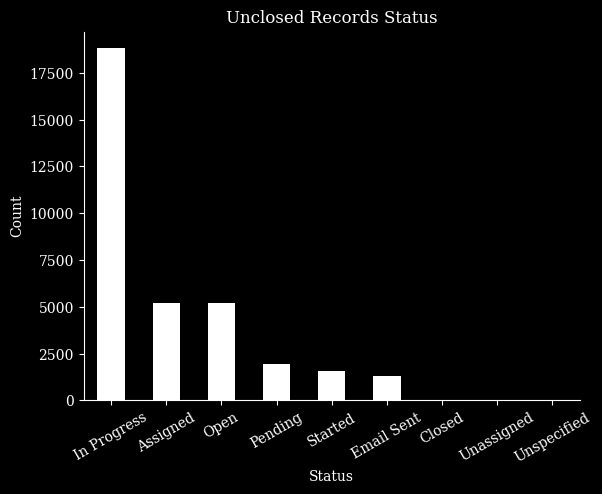

In [435]:
unclosed_status = df[(df['closed_date'].isnull())].groupby('status')['created_date'].count().sort_values(ascending=False)
ax = unclosed_status.plot.bar(title='Unclosed Records Status', ylabel='Count', xlabel='Status', color='w')#.to_clipboard()
ax.set_facecolor((0,0,0,0))
fig = ax.get_figure()
fig.set_facecolor('k')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Other customizations with white for inverted theme
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white', rotation=30)
ax.tick_params(axis='y', colors='white')

In [436]:
df[(df['status']!='Closed')].groupby('agency')['closed_date'].count()
df[(df['borough']=='Unspecified') &  (df['latitude'].isnull()) & (df['incident_zip'].isnull())].count()
# unclosed = df[(df['status']!='Closed')|(df['closed_date'] == pd.NaT)]['agency'].value_counts()
# unclosed.plot.bar(title='Number of Unclosed Requests by Agency', xlabel='Agency', ylabel='Unclosed Request Count')
# unclosed = df[df['status']!='Closed']['agency'].value_counts()
# unclosed.plot.bar(title='Number of Unclosed Requests by Agency', xlabel='Agency', ylabel='Unclosed Request Count')

created_date                      22972
closed_date                       20907
agency                            22972
complaint_type                    22972
status                            22972
resolution_action_updated_date    12162
borough                           22972
descriptor                        22786
resolution_description            22938
incident_zip                          0
city                                  8
latitude                              0
longitude                             0
due_date                          12982
bbl                                   0
dtype: int64

In [437]:
# remove null closed dates
df = df.loc[df['closed_date'].notnull()]

In [438]:
# cl_hr_1 = df['closed_date'].groupby([df['closed_date'].dt.date, df['closed_date'].dt.hour]).value_counts().cumsum()
# conver to hours
# create cumulative sum by summing value count by date for closed date and created date
# subtract the series of cumsums from each other to get number of open per hour

#### Feature Engineering

##### Add target feature

In [439]:
df['hours_to_complete'] =  pd.to_datetime(df['closed_date']) - pd.to_datetime(df['created_date'])
df['hours_to_complete'] = df.loc[:,'hours_to_complete'].astype('float64') / (3.6e12)

##### Add number of requests created by hour and grouped

In [440]:

def add_created_count_feat(df:pd.DataFrame,
                           features:list[str],
                           inplace = False,
                           interval:str = 'H'):
    trunc_name = '_'.join(['created']+[name[:2] for name in features])
    created_by_date = df.groupby(
        by=[
            f'created_{interval}',
            *features
            ]
    )['created_date'].count()

    # ab['time'] = pd.to_datetime(ab['created_date'].astype(str)+' '+ab['hour'].astype(str)+':00:00')
    # ab.drop(['created_date', 'hour'], axis=1, inplace=True)
    # ab.set_index('time', inplace=True)
    if not inplace:
        return created_by_date.unstack(level=features).fillna(0)
    else:
        df.set_index(
            [
                f'created_{interval}',
                *features
            ],
            inplace=True)
        df[trunc_name] = created_by_date.fillna(0)
        df.reset_index(inplace=True)


def add_powerset_created(df:pd.DataFrame, s:set|list, interval:str = 'H'):
    df[f'created_{interval}'] = pd.to_datetime(df['created_date'].astype('int64')).dt.floor(interval)
    df[f'closed_{interval}'] = pd.to_datetime(df['closed_date'].astype('int64')).dt.floor(interval)
    for features in chain.from_iterable(combinations(s, r) for r in range(len(s)+1)):
        start = perf_counter()

        if not features:
            print("general")
            add_created_count_feat(df, features=[], inplace=True, interval=interval)
        # each complaint type seems to be handled by a single agency
        # this reduces runtime a bit by removing this redundancy
        elif 'agency' in features and 'complaint_type' in features:
            continue
        else:
            print(*features)
            add_created_count_feat(df, list(features),inplace=True, interval=interval)
        print(f'{perf_counter()-start:.3f} seconds\n')


##### Add number of requests open by hour grouped by features

In [441]:
def add_open_count(df:pd.DataFrame, interval:str):
    df.set_index([f'closed_{interval}'], inplace=True)
    # sort by closed date
    df.sort_index(axis=0, level=f'closed_{interval}', ascending=True, inplace=True)
    t_num_closed = df['closed_date'].groupby(level=f'closed_{interval}').count()
    t_num_closed:pd.Series = t_num_closed[
        t_num_closed.index.get_level_values(f'closed_{interval}') < df[f'created_{interval}'].max()
        ].cumsum()

    # remove closed date from index
    df.reset_index(f'closed_{interval}', drop=False, inplace=True)
    df.set_index(f'created_{interval}', inplace=True)
    df.sort_index(level=f'created_{interval}', ascending=True, inplace=True)

    # count number created per hour
    t_num_created = df['created_date'].groupby(level=f'created_{interval}').count().cumsum()

    # change index of closed to be more like created
    t_num_closed.index.rename(f'created_{interval}', inplace=True)
    missing_indices = t_num_closed.index.union(t_num_created.index)
    t_num_closed = t_num_closed.reindex(missing_indices, method='ffill')
    t_num_closed.rename(t_num_created.name, inplace=True)

    # display(t_num_closed)
    # display(t_num_created)
    # display(df)
    df["open"] = t_num_created - t_num_closed
    df.reset_index(inplace=True)


def add_open_count_feat(df:pd.DataFrame, features:list[str], interval:str):
    # col name for new feature
    trunc_name = '_'.join(['open']+[name[:2] for name in features])

    # set the index to features and date closed
    df.set_index([f'closed_{interval}']+features, inplace=True)

    # sort by closed date
    df.sort_index(axis=0, level=f'closed_{interval}', ascending=True, inplace=True)

    # count number closed per hour
    t_num_closed = df['closed_date'].groupby(level=list(range(df.index.nlevels))).count()
    t_num_closed:pd.Series = t_num_closed[t_num_closed.index.get_level_values(f'closed_{interval}') < df[f'created_{interval}'].max()]
    t_num_closed = t_num_closed.unstack(level=features, fill_value=0).cumsum()

    # remove closed date from index
    df.reset_index(f'closed_{interval}', drop=False, inplace=True)
    # df.reset_index(features, drop=False, inplace=True)

    # Add created date to index
    df.set_index(f'created_{interval}', append=True, inplace=True)
    # if features:
    #     df = df.reorder_levels(['created_{interval}']+features)
    df.sort_index(level=f'created_{interval}', ascending=True, inplace=True)

    # count number created per hour
    t_num_created = df['created_date'].groupby(level=list(range(df.index.nlevels))).count()

    # unstack to get columns for all features
    # get cumsum over the features then restack into a series
    t_num_created = t_num_created.unstack(level=features, fill_value=0).cumsum()

    # change index of closed to be more like created
    t_num_closed.index.rename(f'created_{interval}', inplace=True)
    missing_indices = t_num_closed.index.union(t_num_created.index)
    t_num_closed = t_num_closed.reindex(missing_indices, method='ffill').stack(level=features)

    # stack back into a series
    t_num_created = t_num_created.stack(level=features)
    t_num_closed.rename(t_num_created.name, inplace=True)

    # difference to get number open at a given hour
    diff = t_num_created - t_num_closed
    # diff:pd.Series = t_num_created.combine(t_num_closed, lambda x,y: x-y, fill_value=0)

    # reorder axis for merger if needed
    if not all([a == b for a, b in zip(diff.index.names, df.index.names)]):
        diff = diff.reorder_levels(df.index.names)

    # add to the dataframe and reset the index
    df[trunc_name] = diff
    df.reset_index(inplace=True)

def add_powerset_open(df:pd.DataFrame, s:set|list, interval:str = 'H'):
    df[f'created_{interval}'] = pd.to_datetime(df['created_date'].astype('int64')).dt.floor(interval)
    df[f'closed_{interval}'] = pd.to_datetime(df['closed_date'].astype('int64')).dt.floor(interval)
    for features in chain.from_iterable(combinations(s, r) for r in range(len(s)+1)):
        start = perf_counter()

        if not features:
            print("general")
            add_open_count(df, interval)
        # each complaint type seems to be handled by a single agency
        # this reduces runtime a bit by removing this redundancy
        elif 'agency' in features and 'complaint_type' in features:
            continue
        else:
            print(*features)
            add_open_count_feat(df, list(features), interval)
        print(f'{perf_counter()-start:.3f} seconds\n')


In [442]:
# calculate number of open requests grouped by
# an element of the powerset of s
s= ['borough', 'agency','complaint_type']
add_powerset_created(df, s)
add_powerset_open(df, s)



general
0.072 seconds

borough
0.445 seconds

agency
0.355 seconds

complaint_type
0.508 seconds

borough agency
0.604 seconds

borough complaint_type
0.874 seconds

general
2.317 seconds

borough
2.285 seconds

agency
2.293 seconds

complaint_type
4.692 seconds

borough agency
4.600 seconds

borough complaint_type
26.598 seconds



In [443]:
df

,borough,complaint_type,created_H,closed_H,agency,created_date,closed_date,status,resolution_action_updated_date,descriptor,...,created_ag,created_co,created_bo_ag,created_bo_co,open,open_bo,open_ag,open_co,open_bo_ag,open_bo_co
0,BRONX,Animal Abuse,2018-04-13 18:00:00,2018-04-13 18:00:00,NYPD,2018-04-13 18:22:30,2018-04-13 18:36:30,Closed,2018-04-13 18:36:30,Tortured,...,111,4,23,1,234,40,104,3,20,0
1,BRONX,Blocked Driveway,2018-04-13 18:00:00,2018-04-13 23:00:00,NYPD,2018-04-13 18:55:19,2018-04-13 23:20:04,Closed,2018-04-13 23:20:04,No Access,...,111,15,23,1,234,40,104,15,20,1
2,BRONX,Consumer Complaint,2018-04-13 18:00:00,2018-04-16 11:00:00,DCA,2018-04-13 18:28:46,2018-04-16 11:34:38,Closed,2018-04-16 11:34:38,Labor Violation,...,4,4,3,3,234,40,4,4,3,3
3,BRONX,Consumer Complaint,2018-04-13 18:00:00,2018-04-16 14:00:00,DCA,2018-04-13 18:25:13,2018-04-16 14:34:12,Closed,2018-04-16 14:34:12,Receipt Incomplete/Not Given,...,4,4,3,3,234,40,4,4,3,3
4,BRONX,Consumer Complaint,2018-04-13 18:00:00,2018-04-29 01:00:00,DCA,2018-04-13 18:21:40,2018-04-29 01:06:33,Closed,2018-04-29 01:06:33,Damaged/Defective Goods,...,4,4,3,3,234,40,4,4,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886364,STATEN ISLAND,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,NYPD,2018-12-31 23:08:31,2018-12-31 23:18:44,Closed,2018-12-31 23:18:44,Loud Music/Party,...,147,80,4,3,90556,4821,953,326,28,9
1886365,STATEN ISLAND,Noise - Residential,2018-12-31 23:00:00,2019-01-01 04:00:00,NYPD,2018-12-31 23:39:46,2019-01-01 04:09:14,Closed,2019-01-01 04:09:14,Banging/Pounding,...,147,80,4,3,90556,4821,953,326,28,9
1886366,STATEN ISLAND,Noise - Residential,2018-12-31 23:00:00,2019-01-01 07:00:00,NYPD,2018-12-31 23:14:00,2019-01-01 07:40:25,Closed,2019-01-01 07:40:25,Loud Music/Party,...,147,80,4,3,90556,4821,953,326,28,9
1886367,STATEN ISLAND,Sewer,2018-12-31 23:00:00,2019-01-02 09:00:00,DEP,2018-12-31 23:36:00,2019-01-02 09:30:00,Closed,2019-01-02 09:30:00,Street Flooding (SJ),...,13,8,1,1,90556,4821,3598,1368,175,61


##### Add some text features for word appearance

In [444]:
most_freq_words = df['resolution_description'].str.split(" ").explode().value_counts().sort_values()
most_freq_words


resolution_description
4                      1
55                     1
3-1-1.                 1
Â Bike-Share           1
Transpiration          1
                  ...   
Department       1564169
and              1565747
of               1722224
The              1900510
the              2867992
Name: count, Length: 1936, dtype: int64

In [445]:
patterns = [
    'responded',
    'completed',
    'insufficient',
    'jurisdiction',
    'review',
    'attempt',
    'investigated',
    ' not ',
    ' no '
]
for pat in patterns:
    df[pat] = df['resolution_description'].str.contains(pat)
    srs = df[df['resolution_description'].str.contains(pat)].groupby('agency')['created_date'].count()
    srs = srs.rename(pat)
    correlation= df[[pat,'hours_to_complete',"complaint_type"]].groupby(["complaint_type"]).corr().dropna()
    correlation = correlation[correlation["hours_to_complete"]<1]['hours_to_complete'].iloc[1::2].sort_values()
    print(correlation)
    display(srs)

complaint_type                     
Panhandling               responded   -0.162629
Drinking                  responded   -0.090175
Noise - Residential       responded   -0.079161
Noise - Vehicle           responded   -0.071262
Illegal Fireworks         responded   -0.048058
Traffic                   responded   -0.033441
Blocked Driveway          responded   -0.020551
Urinating in Public       responded   -0.006086
HEAT/HOT WATER            responded   -0.005904
SAFETY                    responded   -0.004181
GENERAL                   responded   -0.002667
PAINT/PLASTER             responded   -0.001519
FLOORING/STAIRS           responded   -0.001406
ELECTRIC                  responded    0.000376
WATER LEAK                responded    0.002141
Animal Abuse              responded    0.008576
Derelict Vehicle          responded    0.047473
Noise - House of Worship  responded    0.052045
Indoor Air Quality        responded    0.203606
Name: hours_to_complete, dtype: float64


agency
DOHMH         5
HPD       27960
NYPD     485579
Name: responded, dtype: int64[pyarrow]

complaint_type                       
Violation of Park Rules     completed   -0.074922
Street Sign - Dangling      completed   -0.070819
Bus Stop Shelter Complaint  completed   -0.011971
Highway Condition           completed   -0.010369
Sewer                       completed    0.011627
New Tree Request            completed    0.030978
Consumer Complaint          completed    0.074467
Maintenance or Facility     completed    0.089762
Street Condition            completed    0.098349
Highway Sign - Dangling     completed    0.211933
Bridge Condition            completed    0.289464
Public Toilet               completed    0.692003
Name: hours_to_complete, dtype: float64


agency
DCA     5771
DEP      100
DOE     1812
DOT    10363
DPR    11447
Name: completed, dtype: int64[pyarrow]

complaint_type                                 
Transportation Provider Complaint  insufficient   -0.248187
Home Delivered Meal Complaint      insufficient   -0.096300
Taxi Complaint                     insufficient   -0.046012
Panhandling                        insufficient   -0.010366
Derelict Vehicle                   insufficient   -0.009391
Noise - House of Worship           insufficient   -0.007358
Vending                            insufficient   -0.006498
Housing - Low Income Senior        insufficient   -0.006386
Drug Activity                      insufficient   -0.005521
Illegal Parking                    insufficient   -0.005060
Blocked Driveway                   insufficient   -0.002823
Noise - Residential                insufficient   -0.002036
Animal Abuse                       insufficient   -0.000861
Noise - Vehicle                    insufficient    0.000559
School Maintenance                 insufficient    0.020304
Name: hours_to_complete, dtype: float64


agency
DCA       240
DFTA       17
DOE        32
NYPD    15220
TLC         9
Name: insufficient, dtype: int64[pyarrow]

complaint_type                                 
Food Establishment                 jurisdiction   -0.665726
Public Toilet                      jurisdiction   -0.509691
Lifeguard                          jurisdiction   -0.367931
Home Delivered Meal Complaint      jurisdiction   -0.264084
Noise - Helicopter                 jurisdiction   -0.231113
Highway Sign - Missing             jurisdiction   -0.201125
Highway Sign - Damaged             jurisdiction   -0.160803
Overgrown Tree/Branches            jurisdiction   -0.119069
Transportation Provider Complaint  jurisdiction   -0.111854
Posting Advertisement              jurisdiction   -0.104115
Municipal Parking Facility         jurisdiction   -0.091809
Bike Rack Condition                jurisdiction   -0.091645
Street Sign - Damaged              jurisdiction   -0.087454
Consumer Complaint                 jurisdiction   -0.084417
Damaged Tree                       jurisdiction   -0.074049
Elder Abuse                        jurisdiction   -0

agency
DCA      2385
DEP        41
DFTA      122
DHS       812
DOE        45
DOHMH      51
DOITT       3
DOT      3136
DPR      5643
DSNY      612
EDC       550
NYPD     4523
Name: jurisdiction, dtype: int64[pyarrow]

complaint_type                           
Taxi Complaint                     review   -0.248366
Building/Use                       review   -0.176705
General Construction/Plumbing      review   -0.112086
Elevator                           review   -0.099224
Noise - House of Worship           review   -0.054790
Cranes and Derricks                review   -0.050417
Posting Advertisement              review   -0.048551
DOF Parking - Request Status       review   -0.035160
BEST/Site Safety                   review   -0.034548
Vacant Lot                         review   -0.020193
Panhandling                        review   -0.012091
Drinking                           review   -0.010317
Illegal Parking                    review   -0.008636
Executive Inspections              review   -0.008185
Sanitation Condition               review   -0.007229
Housing - Low Income Senior        review   -0.006386
Noise - Vehicle                    review   -0.006068
Noise - Residential                revie

agency
DFTA       100
DHS        812
DOB      10899
DOE         33
DOF        138
DOHMH    29670
DOITT       12
DOT         55
DPR        299
DSNY       612
EDC        240
NYPD     31158
TLC       4167
Name: review, dtype: int64[pyarrow]

complaint_type                                
Interior Demo                          attempt   -0.400134
Sustainability Enforcement             attempt   -0.142598
Plumbing                               attempt   -0.133515
Special Natural Area District (SNAD)   attempt   -0.115596
Home Delivered Meal - Missed Delivery  attempt   -0.103962
Building Marshals office               attempt   -0.094882
Executive Inspections                  attempt   -0.067476
Dead/Dying Tree                        attempt   -0.061136
Senior Center Complaint                attempt   -0.043840
BEST/Site Safety                       attempt   -0.030261
Water Quality                          attempt   -0.027836
ELEVATOR                               attempt   -0.021382
Elevator                               attempt   -0.016800
Illegal Tree Damage                    attempt   -0.012835
Housing - Low Income Senior            attempt   -0.011910
OUTSIDE BUILDING                       attempt    0.006266
HEAT/HOT 

agency
DEP        484
DFTA       112
DOB      19125
DOHMH        1
DPR        692
HPD      55388
Name: attempt, dtype: int64[pyarrow]

complaint_type                                       
Food Establishment                       investigated   -0.741551
Sustainability Enforcement               investigated   -0.659777
Home Delivered Meal Complaint            investigated   -0.264084
Public Toilet                            investigated   -0.140958
Sweeping/Missed                          investigated   -0.136967
Cooling Tower                            investigated   -0.076069
Highway Sign - Damaged                   investigated   -0.049655
Recycling Enforcement                    investigated   -0.018357
Ferry Complaint                          investigated   -0.010812
Boilers                                  investigated   -0.001024
Lead                                     investigated    0.000185
Other Enforcement                        investigated    0.003555
Hazardous Materials                      investigated    0.004175
Collection Truck Noise                   investigated    0.012307
Curb Condition        

agency
DEP      25594
DFTA        31
DOB      52348
DOHMH      651
DOITT       72
DOT       1301
DSNY     64477
Name: investigated, dtype: int64[pyarrow]

complaint_type                      
Noise - Helicopter              not    -0.787916
Public Toilet                   not    -0.541463
Ferry Inquiry                   not    -0.376299
Lifeguard                       not    -0.367931
Highway Sign - Missing          not    -0.294479
                                          ...   
WATER LEAK                      not     0.107064
Electronics Waste Appointment   not     0.158689
Sweeping/Missed                 not     0.188889
Noise                           not     0.198911
Plant                           not     0.423222
Name: hours_to_complete, Length: 64, dtype: float64


agency
DCA            12171
DEP            47011
DFTA              91
DHS            12632
DOB            17029
DOE               60
DOF              122
DOHMH            120
DOITT             63
DOT            11662
DPR            12705
DSNY           24688
EDC              790
HPD           114747
NYC311-PRD         1
NYCEM            144
NYPD           83932
TLC             9960
Name:  not , dtype: int64[pyarrow]

complaint_type                               
Food Establishment                        no    -0.550597
Tanning                                   no    -0.376250
LinkNYC                                   no    -0.203229
Scaffold Safety                           no    -0.195506
Building Marshals office                  no    -0.182869
Highway Sign - Missing                    no    -0.175008
Asbestos                                  no    -0.172648
Collection Truck Noise                    no    -0.172448
Tunnel Condition                          no    -0.144716
Plumbing                                  no    -0.129912
Executive Inspections                     no    -0.111152
Adopt-A-Basket                            no    -0.087033
Maintenance or Facility                   no    -0.062852
Consumer Complaint                        no    -0.059115
Graffiti                                  no    -0.055643
Panhandling                               no    -0.041833
Drinking                  

agency
DCA        1312
DEP       16339
DOB       33642
DOF         236
DOHMH       144
DOITT        17
DOT        1144
DPR        3364
DSNY      54281
HPD       27960
NYPD     208704
Name:  no , dtype: int64[pyarrow]

##### Save new frame to a file

In [446]:
df.to_feather('../data/2018_tf.feather')

In [447]:
# average completion time
completion_time_by_type = df.groupby('complaint_type')['hours_to_complete'].mean()
# number of complaint types
num_of_type = df.groupby('complaint_type')['complaint_type'].value_counts()

In [448]:
bin_lbls = ['Low','Mid','High']
# binning freqency of complaint
q1, bins = pd.qcut(num_of_type, 3, labels=bin_lbls, retbins=True,duplicates='raise')
candidates = q1[q1=='High'].index
# binning completion time
# q2, bins = pd.qcut(completion_time_by_type[completion_time_by_type.index.isin(candidates)], 3, labels=bin_lbls, retbins=True,duplicates='raise')

In [449]:

# get high frequency records
high_freq_df = df[(df['created_date']>df['created_date'].median())&(df['complaint_type'].isin(candidates))]

# row key: [correlation, y_column, [x_columns]]
high_corr = {}
# minimum absolute correlation to be added to the dict
min_corr = 0.3
for col_names in chain.from_iterable(combinations(s, r) for r in range(len(s)+1)):
    if col_names == ():
        continue
    trunc_name = '_'.join(['open']+[name[:2] for name in col_names])
    if trunc_name not in high_freq_df.columns:
        continue
    col_names = list(col_names)
    # get the correlation between completion time and number open for high freq
    consider_df = high_freq_df.groupby(col_names)[['hours_to_complete',trunc_name]]
    correlation:pd.DataFrame = consider_df.corr()
    correlation.drop(trunc_name, axis=1, inplace=True)
    correlation.reset_index(level=-1, drop=True, inplace=True)
    abs_correlation = correlation['hours_to_complete'].abs().iloc[1::2]
    # display(abs_correlation)
    hcorr:pd.Series = abs_correlation[(abs_correlation<1)&(abs_correlation>min_corr)]

    for n, v in hcorr.items():
        tdic = {k:v for k, v in zip(col_names, n)}
        if consider_df.get_group(n)['hours_to_complete'].count() < 1000:
            continue
        if 'complaint_type' in tdic and tdic['complaint_type'] in high_corr:
            continue
        if n not in high_corr:
            high_corr[n] = [v, trunc_name, col_names]
        else:
            high_corr[n] = max(high_corr[n], [v, trunc_name, col_names])
# select complaint types whose completion time is dependent on number of open requests
# high_freq_df = high_freq_df[high_freq_df['complaint_type'].isin(high_corr)]


high_corr

{'DFTA': [0.3089600975238291, 'open_ag', ['agency']],
 'HRA': [0.4961674336632236, 'open_ag', ['agency']],
 'Benefit Card Replacement': [0.4961674336632236,
  'open_co',
  ['complaint_type']],
 'DOF Property - Reduction Issue': [0.3915567377531986,
  'open_co',
  ['complaint_type']],
 'Housing - Low Income Senior': [0.3992625471453151,
  'open_co',
  ['complaint_type']],
 'SCRIE': [0.6280286997260809, 'open_co', ['complaint_type']],
 ('Unspecified', 'HRA'): [0.4961674336632236,
  'open_bo_ag',
  ['borough', 'agency']]}

In [464]:
# remove outlier records
quants_df = high_freq_df.groupby('complaint_type')['hours_to_complete'].quantile([0.25,0.75])
quants_df = quants_df.unstack()
out_max = (quants_df[0.75] - quants_df[0.25])*1.5
# quants_df.columns

In [465]:
high_freq_df = pd.merge(high_freq_df, out_max.rename('upper_bound'), left_on='complaint_type', right_index=True)
high_freq_df = high_freq_df[high_freq_df['hours_to_complete'] < high_freq_df['upper_bound']]
high_freq_df.drop('upper_bound', axis=1, inplace=True)

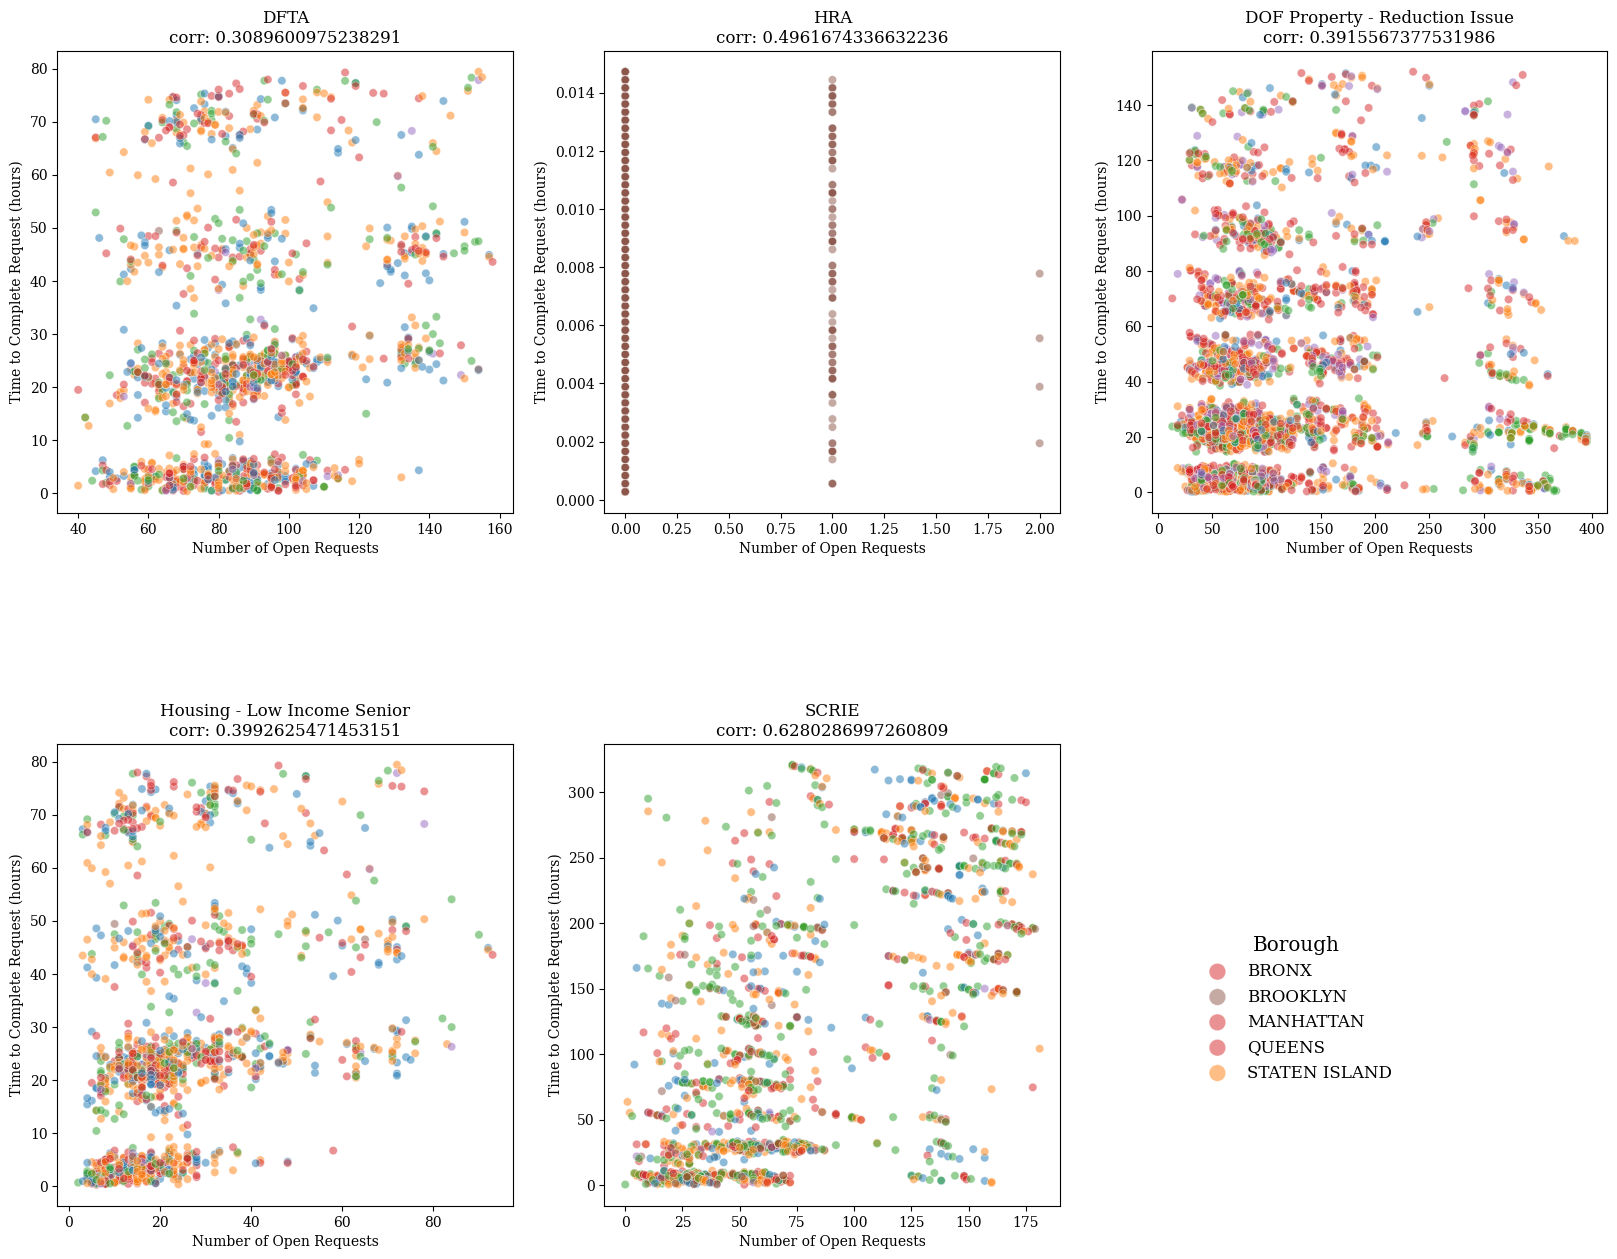

In [466]:
final_set = []
corr_nums = set()
# graph hexbins for high corr, high frequency complaint types
for n, (corr, x, c) in high_corr.items():
    if corr not in corr_nums:
        corr_nums.add(corr)
    else:
        continue
    try:
        grp = high_freq_df.groupby(c).get_group(n)
    except KeyError:
        continue
    if isinstance(n, tuple):
        name = ' :: '.join(n)
    else:
        name = n

    title = f'{name}\ncorr: {corr}'
    final_set.append((n,title, x, c))

def nearest_rectangle(num_vars:int):
    length = width = round(num_vars**0.5)

    if length * width < num_vars:
        width += 1

    return length, width

height, width = nearest_rectangle(len(final_set))

boroughs = list(df['borough'].unique())
borough_colors = {b:c for b,c in zip(boroughs, plt.cm.rainbow(np.linspace(0, 1, len(boroughs))))}


fig, axes = plt.subplots(
            nrows=height,
            ncols=width,
            squeeze=False
            # subplot_titles=subplot_titles
        )


fig.set_size_inches(20,15)
plt.subplots_adjust(hspace=0.5)
for (i, ax), (n, title, x, c) in zip_longest(np.ndenumerate(axes), final_set, fillvalue=('_','_','_','_')):
    if n == '_':
        ax.set_axis_off()
        continue
    grp = high_freq_df.groupby(c).get_group(n)
    sns.scatterplot(
        y='hours_to_complete',
        x=x,
        hue='borough',
        hue_order=borough_colors,
        data=grp,
        alpha=0.5,
        ax = ax,
        legend=False,
        )
    ax.set_xlabel("Number of Open Requests")
    ax.set_ylabel('Time to Complete Request (hours)')
    ax.set_title(title)




leg = fig.legend(
    labels=boroughs,
    # handles=handles,
    bbox_to_anchor=[.3,-.2,0.5,0.5],
    fontsize='large',
    markerscale=2,
    frameon=False,
    title="Borough",
    title_fontsize='x-large',
    draggable=True
    )




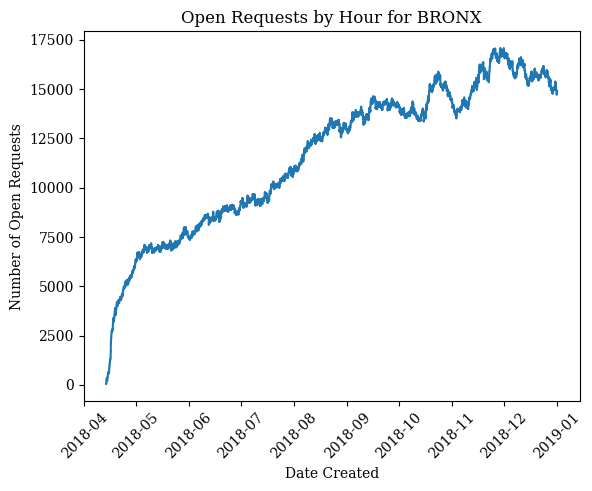

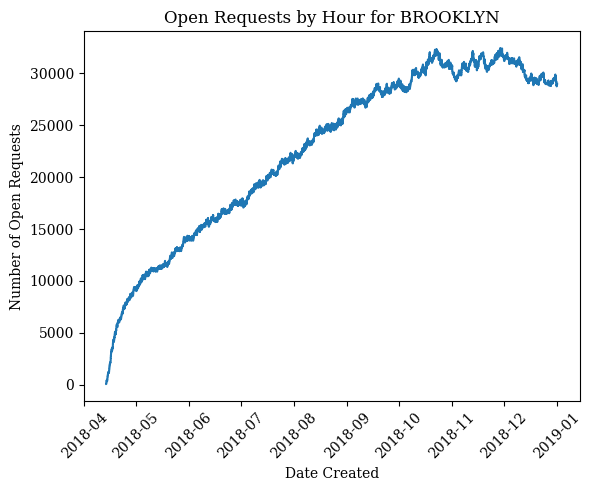

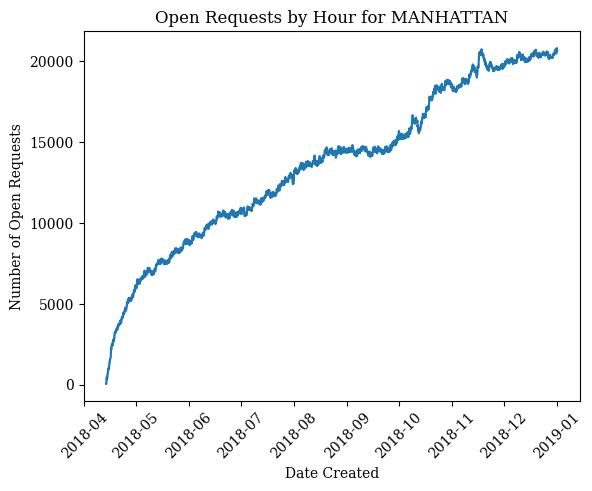

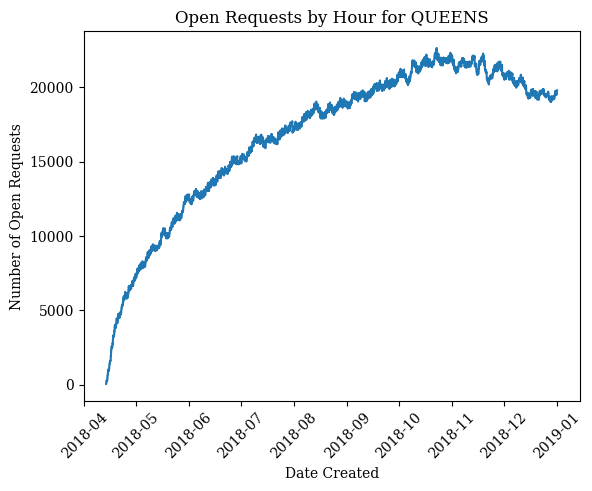

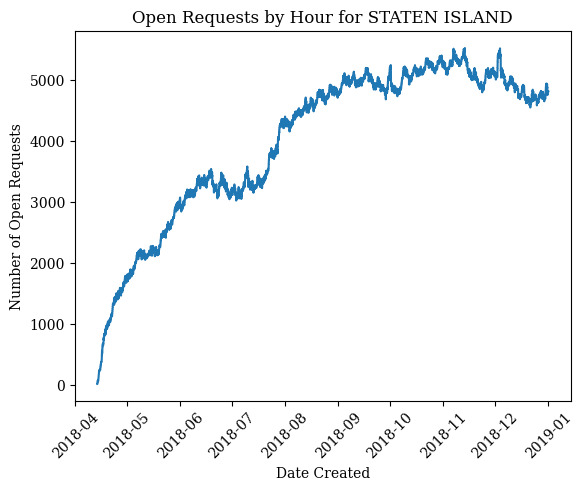

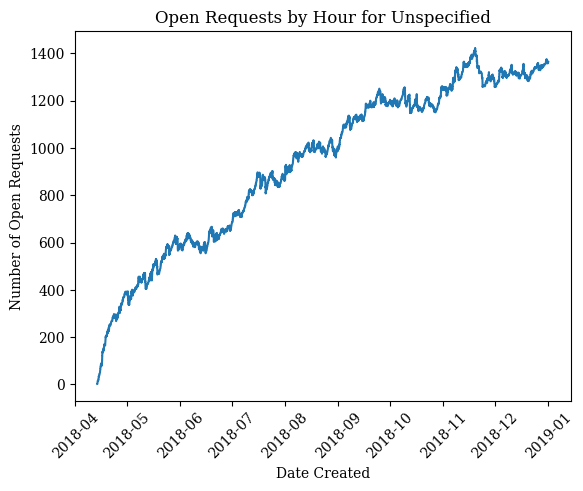

In [81]:
# graph number of open requests by borough for the sample
for n, grp in df.groupby(['borough']):
    # forward fill for missing days and fill first day w/ 0
    grp['open_bo'] = grp['open_bo'].ffill().fillna(0)
    ax = grp.plot(x='created_date', y='open_bo', title=f'Open Requests by Hour for {n[0]}', legend=False)
    ax.set_xlabel('Date Created')
    ax.set_ylabel('Number of Open Requests')
    ax.tick_params(axis='x',rotation=45)


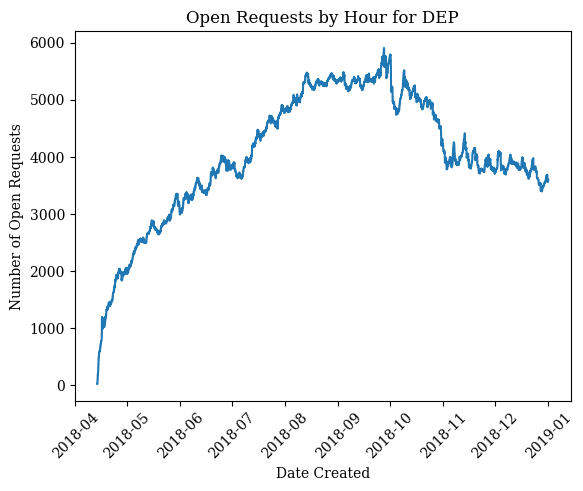

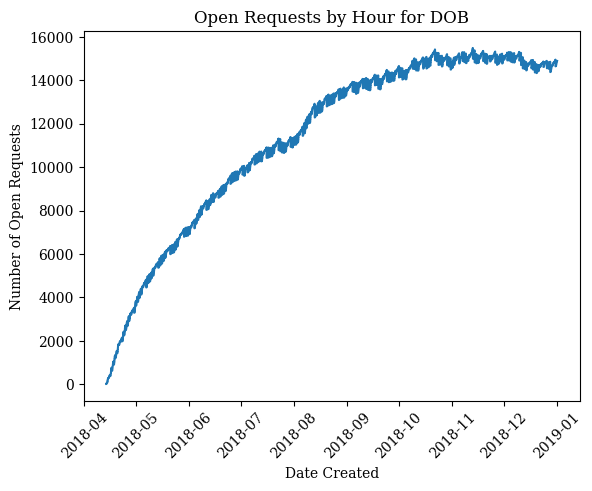

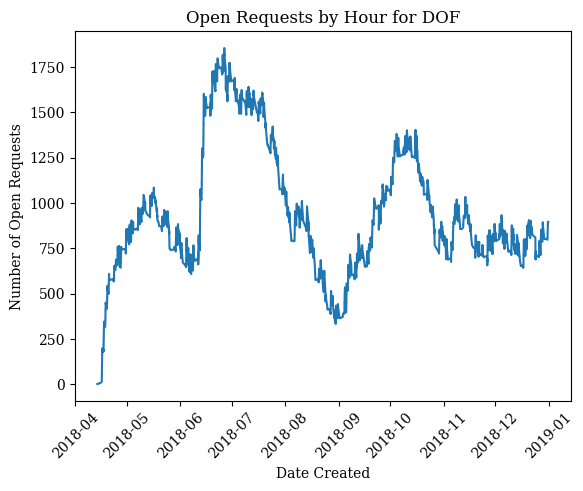

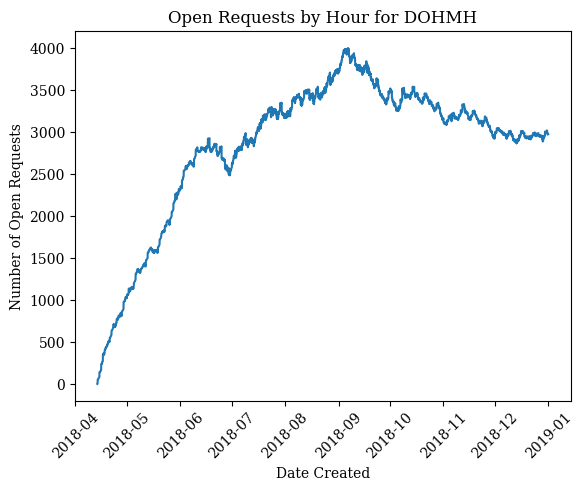

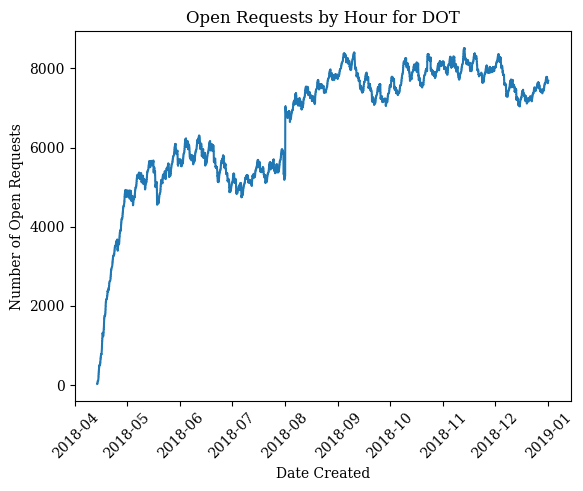

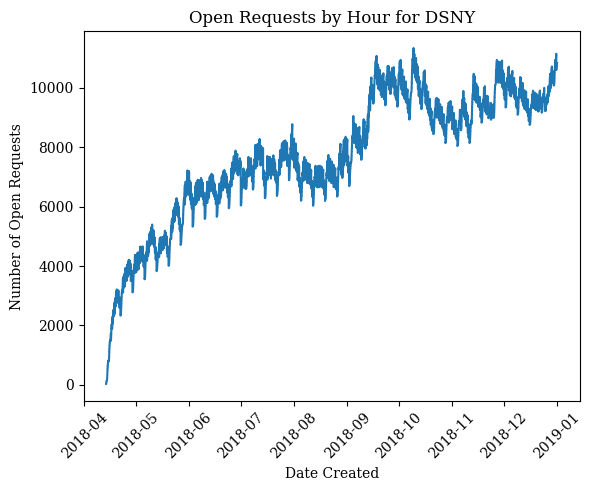

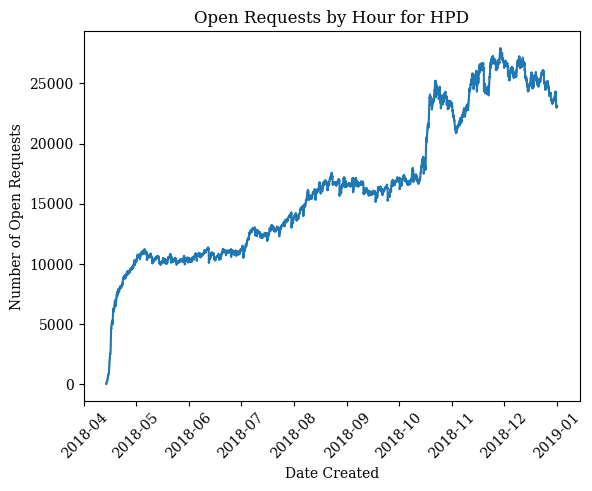

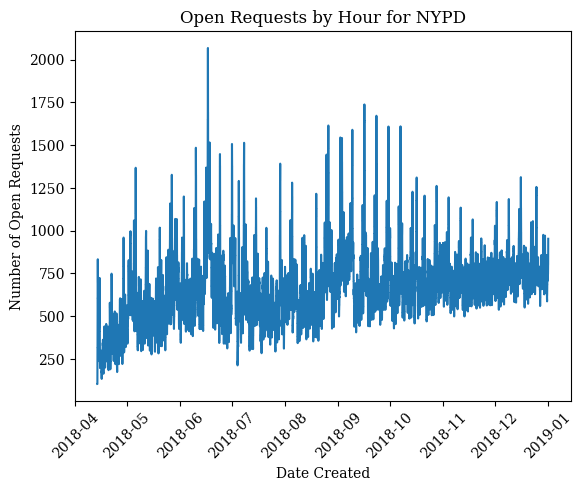

In [79]:
# graph number of open requests by agency for the sample
# df[df['open_bo']>0].groupby('borough').plot(x='created_date', y='open_bo')
high_freq = ['HPD', 'NYPD', 'DSNY', 'DOT', 'DEP', 'DOB', 'DOF', 'DOHMH']
for n, grp in df[df['agency'].isin(high_freq)].groupby(['agency']):
    # forward fill for missing days and fill first day w/ 0
    grp['open_ag'] = grp['open_ag'].ffill().fillna(0)
    ax = grp.plot(x='created_date', y='open_ag', title=f'Open Requests by Hour for {n[0]}', legend= False)
    ax.set_xlabel('Date Created')
    ax.set_ylabel('Number of Open Requests')
    ax.tick_params(axis='x',rotation=45)


### Time Series Analysis

In [ ]:
df = df.dropna(axis=0)


In [ ]:
# df.columns = ['borough', 'agency', 'created_date', 'closed_date', 'complaint_type',
#        'status', 'resolution_action_updated_date', 'descriptor',
#        'resolution_description', 'incident_zip', 'city', 'latitude',
#        'longitude', 'due_date', 'bbl', 'hours_to_complete', 'open',
#        'open_ag_br', 'open_ag', 'open_br']
df.columns = [
       'borough', 'agency',
       'ds', 'closed_date',
       'complaint_type', 'status',
       'resolution_action_updated_date', 'descriptor',
       'resolution_description', 'incident_zip',
       'city', 'latitude',
       'longitude', 'due_date',
       'bbl', 'hours_to_complete',
       'open', 'y',
       'open_ag', 'open_br'
]


In [ ]:
# heirarchies = [
#     ['borough'],
#     [ 'borough','incident_zip'],
#     [ 'borough','incident_zip', 'agency'],
#     [ 'borough','incident_zip', 'agency', 'complaint_type'],
# ]
hdf = df[df['borough']!= 'Unspecified']
bdf, H_df, tags = aggregate(
    hdf,
    spec=[['agency','borough']]
)

In [ ]:
bdf

In [ ]:
hrec = HierarchicalReconciliation(
    reconcilers =
        [
            MinTrace('ols', nonnegative=True,num_threads=-1),
            # ERM('closed'),
            # BottomUp()
        ]
)


In [ ]:


Y_df = bdf[(bdf['ds']>datetime.date(year=2018, month=10, day=1)) & (bdf['ds']<datetime.date(year=2018, month=12, day=1))]
Y_df

In [ ]:

models = [MSTL(
    season_length=[24, 24 * 7], # seasonalities of the time series
    trend_forecaster=AutoARIMA(trace=True) # model used to forecast trend
)]
sf = StatsForecast(
    models = models,
    freq = 'H',
    df=Y_df,
    n_jobs=-1
    )
sf.fit()

In [ ]:
fcts  = sf.forecast(h=1,df=bdf, level=[90])

In [ ]:
fcts

In [ ]:
StatsForecast.plot(df=Y_df, forecasts_df=fcts[fcts.index.isin(bdf.index)].fillna(0))